<img src="images/header.png" alt="Header" style="width: 400px;"/>
<h1 align="center">Predictive Maintenance using NVIDIA RAPIDS and Deep Learning Models</h1>
<h4 align="center">Part 3: Training Autoencoder for Anomaly Detection</h4>

## Overview

In the previous lab, we used LSTMs to predict hard drive failures. While timeseries prediction is a very well-studied approach in predictive maintenance, in this section we focus on a different deep learning technique, which is called __anomaly detection__. In a nutshell, considering the fact that only a small portion of the hard drives are defective in our use case, we can treat those as anomalies. For example, out of three million samples we dealt with in our training set within the previous lab, only 256 samples were defective. Those are "anomalies" among the big pool of well-functioning hard drives. Now, if we could have a model capable of learning what a proper functioning hard drive looks like, it could detect hard drives with a different behavior pattern.


This lab covers the following topics:

* [Autoencoders](#1)
    * [Exercise 1: Retrieve the output labels](#e1)
    * [Exercise 2: Filtering the labels](#e2)
    * [Testing Models](#2)
        * [LSTM Autoencoder Model](#3)
        * [1D Convolution Model](#3b)
* [Hyperparameter Optimization](#e4)
    * [Exercise 3: Experimenting with Hyperparameters](#e4)
    * [Exercise 4: Update code to use specified validation data](#e5)
    * [Exercise 5: Create HPO result plots](#e6)

In this lab, we will leverage the same Backblaze Hard Drive SMART data to train an Autoencoder model that will detect anomaly activity.  We'll leverage the time series sequences that we created in the previous step to train an Autoencoder Model to identify when there are significant variances from expected sensor data.  These variances can be used to alert support teams that there are potential issues with the system.

You'll see that autoencoders (AEs) are relatively easy to use, but let's first walk through the basics of using autoencoders.

We can use unsupervised learning algorithms like a deep autoencoder network to perform anomaly detection. A deep autoencoder takes an input X and attempts to map it back to itself; in essence, the autoencoder is trying to learn the identity function of the input data. Since learning the identity function is pretty trivial, we force the hidden layers of our autoencoder to be of lower dimensionality than the previous layer. This constraint forces the autoencoder to learn patterns in the data, and really learn efficient representations.

<img src="img/AE_img-2.png" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 1. Using an autoencoder to map a timeseries data back to itself</p>

To train this type of neural network, we can calculate the difference between the input and the output and use that loss, typically called a reconstruction loss, as our loss function for training our model. The idea is that our autoencoder is essentially learning the data generating distribution for a unique dataset, and when we feed data generated from a different distribution into our autoencoder, our autoencoder will do a very poor job of reconstructing the input from the second source and our reconstruction error will be high; this indicates that our input is anomalous instead of just an extreme value.

<img src="img/AE_img-3.png" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 2. The predicted and ground-truth timeseries comparison after applying the autoencoder</p>



<a name="1"></a>
## Autoencoders

Autoencoders are a subset of neural network architectures where the output dimension is the same as the input dimension. Autoencoders have two networks, an encoder and a decoder.  The encoder encodes its input data into a smaller dimensional space, called the latent space.  The decoder network tries to reconstruct the original data from the latent encoding. Typically, the encoder and decoder are symmetric, and the latent space is a bottleneck. The autoencoder has to learn essential characteristics of the data to be able to do a high-quality reconstruction of the data during decode.



<img src="img/AE_img-1.png" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 3.  Structure of an auto-encoder model</p>

Autoencoders can be built using many different layer types based on the desire goal of the model.  In this lab, we'll experiment using two different autoencoder models.  One built with LSTM layers and one built on top of 1D-Convolution.  You'll have the opportunity to test both.  Additionally, you'll see that we leverage Dropout layers as a way to control overfitting by randomly omitting subsets of features at each iteration of a training procedure. To begin, let’s import some libraries that we are going to use throughout this lab.

In [ ]:
# Import libraries that will be needed for the lab
import os
import sys
import time
import logging
import importlib
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score, precision_recall_curve, auc, confusion_matrix,accuracy_score

from tensorflow.keras import initializers, regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate

from tensorflow.keras import backend as K

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import *

import pickle
import gc

import random

random.seed(123)

<a name="1b"></a>
### Input Data Set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data_dir = "./data/"

#print('Using 16-day sequence data set')
sequence_length = 16        # Number of days in sequence to train
#wsize = 16
#train_fname = data_dir + 'Lab3-AE-train-16day-8step.pkl'
#test_fname = data_dir + 'Lab3-AE-test-16day-8step.pkl'
sequence_length

16

### Data Set Information

As we experienced in the previous exercises, preparing large data sets can take some time.  So, for this exercise, we have created larger training and validation datasets which we will use for our training and testing.  

The datasets consists of 50000 sequences.  Each sequence is for an individual drive and tracks the SMART data features over 7 continuous days.  Since we will be training an Autoencoder to identify sequences for normal hard drive operation, we have not include any sequences that ended in drive failures.

When we created these sequences, we assigned them a sequence id (field: "ae_seq_id") and a day number in the sequence (field: "ae_seq_data_id" which goes from 0-15).

### Reading Training and Validation Datasets

In [ ]:
# Reading larger training and test data set with only ST4000DM000 data
#df = pd.read_pickle(train_fname)
df = pd.read_csv('/content/drive/MyDrive/ForCoding/predictive_maintenance.csv')

print('Original shape:', df.shape)
df

Original shape: (10000, 10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


Let's take a look at our data set.  We'll print out the first 2 sequences.  You'll see the sequence id fields we discussed above.

In [ ]:
encoder = LabelEncoder()
df['Type'] = encoder.fit_transform(df['Type'])
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,1,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,1,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,1,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,1,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,2,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,0,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,2,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,0,299.0,308.7,1408,48.5,25,0,No Failure


In [ ]:
df.head(2*sequence_length)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,1,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,1,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,1,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,1,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,2,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,1,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,1,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,2,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,2,298.5,309.0,1741,28.0,21,0,No Failure


### Data preparation Routines

To work with the data, we are going to build a more structured set of functions that are going to help us with data curation. As stated in the previous lab, the dataset contains duplicated columns with "normalized" data. Our first function, `remove_normalized`, is aimed to remove those.

In [ ]:
df.columns[3].lower().find("normalized")

-1

In [ ]:
# Remove the "normalized" columns which are simply nomralized copies of the "raw" column

def remove_normalized(df):
    cols = [c for c in df.columns if (c.lower().find("normalized")==-1)]
    df=df[cols]
    return df

<a name="e1"></a>

### Exercise 1: Retrieve the output labels

We would like to get the failure column in NumPy format. Please complete the following function to perform return the appropriate labels:

In [ ]:
def get_Labels(df):
    # return the proper column in NumPy format
#     << TO DO >>
    y_labels = df['Target'].values
    return y_labels

Click [here](#a1) for answer

### Sort data based on `ae_seq_id` and `ae_seq_data_id` columns

Prior to training, we need to ensure that all the data is properly sorted so that sequences are presented in the correct order.  Typically, we would sort the data by unique id and date/time.  When we created the data set for this exercise, we added two fields:
<ul>
    <li>ae_seq_id: Id number of unique sequence</li>
    <li>ae_seq_data_id: Day number of record in sequence (day 0 - day (sequence_length-1))</li>
</ul>

In [ ]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,1,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,1,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,1,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,1,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
# Sort data frame to ensure proper order

def sort_dataframe(df):
    print("Sorting the data frame based on pre-created sequence id and sequence day id")
    df['UDI'] = pd.to_datetime(df['UDI'])

    #sort dataframe by 'ae_seq_id' and 'ae_seq_data_id'
    #df = df.sort_values(by=['ae_seq_id', 'ae_seq_data_id'], axis=0, ascending=True)
    df = df.reset_index(drop=True)
    return df

Next we have created some "helper" functions to:
<ul>
    <li>Remove columns that possess no useful information for training</li>
    <li>Normalize the columns</li>
</ul>

In [ ]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [ ]:
# Remove columns unnecessary for training

def remove_columns(df, drop_columns_list = ['Product ID',
                                               'Failure Type']):
    print("removing unnecessary columns")
    df = df.drop(columns=drop_columns_list)
    df = df.reset_index(drop=True)
    return df

In [ ]:
# This routine removes the normalized features and removes unnecessary columns

def clean_dataframe(df,column_list=None):

    #sort the dataframe
    df = sort_dataframe(df)

    #remove normalized columns
    df = remove_normalized(df)

    #remove other unnecessary columns
    if column_list is not None:
        df = remove_columns(df, column_list)

    return df

# This routine scales values for training and reshapes data as appropriate for LSTM or CONV1D training

def normalize_df(df, ae_type=None,scaler=None):

    print("Normalizing input for "+ae_type)
    #normalize data with max/min values
    df.fillna(0, inplace=True)
    x = df.values
    x = x.astype(np.float64)
    if scaler is None:
        scaler = preprocessing.StandardScaler().fit(x)
    x = scaler.transform(x)

    #reshape to obtain appropriate input for autoencoder
    if ae_type == "lstm":
        x = x.reshape(int(x.shape[0]/sequence_length), sequence_length, x.shape[1])
    elif ae_type == "conv1d":
        tshape = x.shape
        print(tshape, "dropping ", tshape[0]-int(tshape[0]/w_size)*w_size, end = " : reshaping to ")
        x = x[:int(tshape[0]/w_size)*w_size,:].reshape(int(tshape[0]/w_size), w_size, tshape[1])

    print(x.shape)

    return x, scaler

We are going to load both training and test sets below, starting with the training set. Note that unlike the LSTM models, here we do not require the `failure` columns. The class labels are not what we learn, rather we learn the training data pattern. In that sense, autoencoders are unsupervised models.

In [ ]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [ ]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,1,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,1,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,1,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,1,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
y_labels = get_Labels(df)
#y_labels = [x_train[i+1,6] for i in range(len(x_train) - 16-1)]
y = y_labels
len(y)

10000

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df, y, test_size=0.2, random_state=40)

In [ ]:
x_train.shape

(8000, 10)

In [ ]:
x_test.shape

(2000, 10)

In [ ]:
print("processing the train set")

x_train = clean_dataframe(x_train,['UDI','Product ID',
                               'Failure Type'])

x_train, scaler = normalize_df(x_train,"lstm")

processing the train set
Sorting the data frame based on pre-created sequence id and sequence day id
removing unnecessary columns
Normalizing input for lstm
(500, 16, 7)


In [ ]:
x_train.shape

(500, 16, 7)

In [ ]:
print("processing the test set")

x_test = clean_dataframe(x_test,['UDI','Product ID',
                               'Failure Type'])

x_test, scaler = normalize_df(x_test,"lstm")

processing the test set
Sorting the data frame based on pre-created sequence id and sequence day id
removing unnecessary columns
Normalizing input for lstm
(125, 16, 7)


In [ ]:
x_test.shape

(125, 16, 7)

In [ ]:
x_train.shape[2]==len(df.columns)

False

In [ ]:
#x_train = pd.DataFrame(df, columns=df.columns, index=df.index)
#x_train
len(y_test)

2000

Let's take a look at a few samples of the data.

Next, we are going to load the test set. Unlike, the train set, we require the `failure` column for the test set to evaluate the model accuracy at the end. Again, you can see that we are using the processed dataset from the previous lab for our test purposes.

In [ ]:
print('x_train:',x_train.shape,'\n')
print('x_test:',x_test.shape,'\n')
print('y_train:',len(y_train),'\n')
print('y_test:',len(y_test),'\n')

x_train: (500, 16, 7) 

x_test: (125, 16, 7) 

y_train: 8000 

y_test: 2000 



<a name='e2'></a>
### Exercise 2: Filtering the labels

As for class labels, there is one extra filtering step. Take some time and try to figure the purpose behind the following command:

In [ ]:
y_seq_train = y_train[sequence_length-1::sequence_length]
y_seq_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_seq_train.shape

(500,)

In [ ]:
y_seq_test = y_test[sequence_length-1::sequence_length]
y_seq_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_seq_test.shape

(125,)

To label a particular sequence as normal or failed, we will use the 'failure' column from the last day of the sequence.  The above code finds the last day failure label to label the entire sequence.

# Part 1 - LSTM based autoencoder or seq2seq model

<a name="2"></a>
## Defining the LSTM Autoencoder Model

In this section, we are going to define two autoencoder models. The first model uses LSTMs as autoencoders. In this model, we create the autoencoder for time sequences using LSTM encoder-decoder models.

An LSTM unit could be thought of an encoder unit where the input data are represented as a vector of a hidden states. We use this concept to encode the input into 1024 __bottleneck__ vectors. Afterwards we use another set of two LSTM units to reconstruct the original series.

For the second model, we use a convolutional autoencoder. In this model, in order to encode the information, we use down-sampling (MaxPooling1D) and up-sampling (UpSampling1D) methods.

In [ ]:
# Model #1 - Wide LSTM-based Encoder-Decoder
data_shape = x_train.shape[1:]

## Some parameters to change
dp_lvl = 0.2
lstm_width = 128

inputs = Input(shape=(data_shape))
encoded = LSTM(lstm_width, dropout = dp_lvl, recurrent_dropout = dp_lvl, return_sequences =  False, activation='relu')(inputs)
decoded = RepeatVector(data_shape[0])(encoded)
decoded = LSTM(lstm_width, return_sequences=True, activation='relu')(decoded)
decoded = LSTM(lstm_width, return_sequences=True, activation='relu')(decoded)
decoded = LSTM(lstm_width, return_sequences=True, activation='relu')(decoded)
decoded = LSTM(lstm_width, return_sequences=True, activation='relu')(decoded)
decoded = LSTM(lstm_width, return_sequences=True, activation='relu')(decoded)
decoded = LSTM(lstm_width, return_sequences=True, activation='relu')(decoded)
decoded = Dropout(0.1)(decoded)
decoded = LSTM(data_shape[1], activation='tanh', return_sequences=True)(decoded)

# Build entire model
autoencoder = Model(inputs, decoded)

# Parameters to control learning rate
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])

print(autoencoder.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 16, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 128)                 │          69,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 16, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 16, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 16, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 16, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 16, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 16, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 16, 7)               │           3,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 862,944 (3.29 MB)

 Trainable params: 862,944 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

None


We setup callback routines to two callback routines
<ul>
    <li>ModelCheckpoint - stores a copy of our model weights for our best training epoch.  This can be used for later deployments.</li>
    <li>EarlyStopping - stops the training early if the model is no longer improving.</li>
</ul>

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint
checkpoint = ModelCheckpoint("best_model_ae-lstm.keras", monitor='val_loss',
                             verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(patience=20, verbose=1)

callbacks_list = [es, checkpoint]

<a name="3"></a>
## Training the LSTM model
Now that we've created our model, we'll go ahead and train it.  Then we'll evaluate the performance.

In [ ]:
# train the model

# number of training epochs - feel free to change
#
# Time: 60 epochs ~= 3 minutes for LSTM

epochs_num = 200
history = autoencoder.fit(x_train, x_train, batch_size=15, epochs=epochs_num, validation_split=0.1, verbose=1, callbacks=callbacks_list)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.1738 - loss: 0.7412
Epoch 1: val_loss improved from inf to 0.71859, saving model to best_model_ae-lstm.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.1735 - loss: 0.7408 - val_accuracy: 0.1200 - val_loss: 0.7186
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.1293 - loss: 0.7117
Epoch 2: val_loss improved from 0.71859 to 0.71321, saving model to best_model_ae-lstm.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.1293 - loss: 0.7116 - val_accuracy: 0.1587 - val_loss: 0.7132
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.1415 - loss: 0.7051
Epoch 3: val_loss improved from 0.71321 to 0.70949, saving model to best_model_ae-lstm.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.1411 - loss: 0.7051 - val_accuracy: 0.1650 - val_loss: 0.7095
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1308 - loss: 0.7049
Epoch 4: val_loss improve

Let's look at the loss function to see how accurate our training was.  

In [ ]:
# load weights from best model
print("best_model_ae-lstm.keras")
autoencoder.load_weights("best_model_ae-lstm.h5")

best_model_ae-lstm.keras


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model_ae-lstm.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

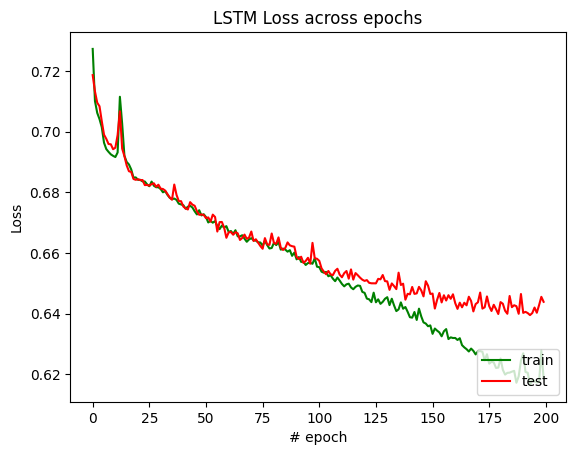

In [ ]:
# show plot Loss changes during training

plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'r')
plt.title('LSTM Loss across epochs')
plt.ylabel('Loss')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

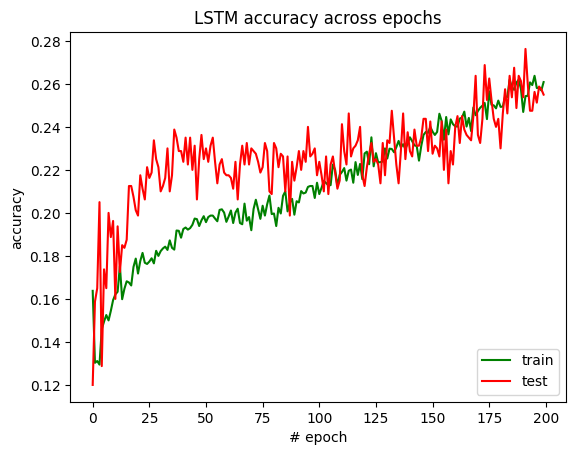

In [ ]:
# show plot accuracy changes during training

plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'r')
plt.title('LSTM accuracy across epochs')
plt.ylabel('accuracy')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

The model is starting to get trained, but at this point, the accuracy may not be that great.  In the real world, we train on even larger data sets for longer periods of time until the accurracy met our business requirements.  We also review the model and can increase it's complexity.

Let's go ahead and use our model to make predictions on the test data.  Remember, this is a reconstruction model, so the predictions, ideally, should look similar to the original data for normal disks.

In [ ]:
# Use model to predict on test data set
y_pred = autoencoder.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step


In [ ]:
y_pred.shape

(125, 16, 7)

The next cell will plot a comparison of the original data to the predicted data for a random record. It compares the features for the first day in the sequence. Run it a few times to see how well your model came out.

This record is from a normal disk.


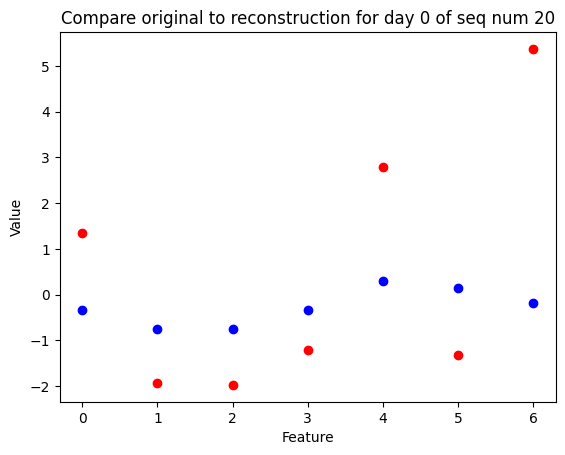

In [ ]:
# create horizontal positions for scatter plot
x_pos = np.arange(x_test.shape[2])

# select random record
rec_num = random.randint(0, y_pred.shape[0])

# plot predicted points
plt.scatter(x_pos, x_test[rec_num,0,:], c="#ff0000")
plt.scatter(x_pos, y_pred[rec_num,0,:], c="#0000ff")

# label graph
plt.xlabel("Feature")
plt.ylabel("Value")
plt.xticks(range(x_test.shape[2]))
plt.title("Compare original to reconstruction for day 0 of seq num " + str(rec_num))

if y_seq_test[rec_num] == 0:
    print("This record is from a normal disk.")
else:
    print("This record is from an anomalous disk.")

You'll see that once you have a trained model, you need to determine a "threshold" of difference in detecting an anomaly. In our case, we know the number of normal disks and the number of anomalous disks. We'll calculate the MSE for each reconstruction and set our initial threshold based on that. This should be a good point to start the threshold at. In real world usage, you'll adjust the model and threshold to obtain accuracy to meet your business needs. In our case we'd like the recall to be as high as possible to identify as many failing disks as possible.

In [ ]:
# Calcuate MSE for all sequences and predictions
import statistics

# determine median mse to split data into normal vs anomaly
pred_mse = []  # calculated mse for test data
pred_res = []  # result: 0 normal, 1 anomaly

for i in range(len(x_test)):
    pred_mse.append(mean_squared_error(y_pred[i,:,:], x_test[i,:,:]))

# Find number of disks that we know are normal and use that value as splitting point for data
num_normal_disks = list(y_seq_test).count(0)

sort_mse = pred_mse.copy()
sort_mse.sort()
suggested_threshold = sort_mse[num_normal_disks]
print("Suggested Threshold:", suggested_threshold)

Suggested Threshold: 1.5769059770458724


In [ ]:
# Routine to specify whether or not a sequence is anomalous

# specify override threshold or leave 0 to use suggested threshold
override_threshold = 0

if override_threshold == 0:
    threshold = suggested_threshold
else:
    threshold = override_threshold

for mse in pred_mse:
    if (mse <= threshold):
        pred_res.append(0)
    else:
        pred_res.append(1)

print("Used threshold:", threshold)
print("Resulting in the following classification of predicted data:")
print("- Normal Disks:   ", pred_res.count(0))
print("- Anomalous Disks:", pred_res.count(1))

Used threshold: 1.5769059770458724
Resulting in the following classification of predicted data:
- Normal Disks:    122
- Anomalous Disks: 3


<a name="3b"></a>
## Training the 1D Convolutional model
Now that we've tested our LSTM model, let's create and train a 1D-Convolutional model.

In [ ]:
checkpoint2 = ModelCheckpoint("best_model_ae-conv1d.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es2 = EarlyStopping(patience=20, verbose=1)

callbacks_list2 = [es2, checkpoint2]

Let's build out a 1D Convolution Model:

In [ ]:
# Traditional Conv1D model

# Model parameter settings
sample_size = x_train.shape[1]
num_signals = x_train.shape[2]
dropout_rate = 0.2
outside_filters = 160
inside_filters = 80
ksize=6

# TTraditional 1D-Convolution Autoencoder

input_data = Input(shape=(sample_size, num_signals))
# --- Encode ---
encoded = Conv1D(filters=outside_filters, kernel_size=ksize, activation="relu", padding="same")(input_data)
encoded = MaxPooling1D(pool_size=2)(encoded)
encoded = Dropout(rate=dropout_rate)(encoded)
encoded = Conv1D(filters=inside_filters, kernel_size=ksize, activation="relu", padding="same")(encoded)
encoded = MaxPooling1D(pool_size=2)(encoded)
encoded = Dropout(rate=dropout_rate)(encoded)
# --- Encodings ---
encoded = Conv1D(filters=4, kernel_size=ksize, activation="relu", padding="same")(encoded)
encoded = Dropout(rate=dropout_rate)(encoded)
# --- Decode ---
decoded = UpSampling1D(size=2)(encoded)
decoded = Conv1D(filters=inside_filters, kernel_size=ksize, activation="relu", padding="same")(decoded)
decoded = Dropout(rate=dropout_rate)(decoded)
decoded = UpSampling1D(size=2)(decoded)
decoded = Conv1D(filters=outside_filters, kernel_size=ksize, activation="relu", padding="same")(decoded)
decoded = Dropout(rate=dropout_rate)(decoded)
# --- Output ---
output_layer = Conv1D(filters=num_signals, kernel_size=1, activation="linear", padding="same")(decoded)
autoencoder2 = Model(input_data, output_layer)
lr = 1e-3 # learning rate
autoencoder2.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])
autoencoder2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 16, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 16, 160)             │           6,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 8, 80)               │          76,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 4, 4)                │           1,924 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d (UpSampling1D)         │ (None, 8, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 8, 80)               │           2,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_1 (UpSampling1D)       │ (None, 16, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 16, 160)             │          76,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 160)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 16, 7)               │           1,127 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,771 (647.54 KB)

 Trainable params: 165,771 (647.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the model

# number of training epochs - feel free to change
#
#       100 epochs ~= 3 minutes for Conv 1D

epochs_num = 200
history2 = autoencoder2.fit(x_train, x_train, batch_size=128, epochs=epochs_num, validation_split=0.1, verbose=1, callbacks=callbacks_list2)


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1526 - loss: 1.0005
Epoch 1: val_loss improved from inf to 1.00448, saving model to best_model_ae-conv1d.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.1525 - loss: 1.0004 - val_accuracy: 0.1150 - val_loss: 1.0045
Epoch 2/200
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1422 - loss: 1.0216
Epoch 2: val_loss improved from 1.00448 to 0.99969, saving model to best_model_ae-conv1d.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.1407 - loss: 1.0120 - val_accuracy: 0.1388 - val_loss: 0.9997
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1766 - loss: 0.9977
Epoch 3: val_loss improved from 0.99969 to 0.98559, saving model to best_model_ae-conv1d.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1777 - loss: 0.9963 - val_accuracy: 0.2138 - val_loss: 0.9856
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1914 - loss: 0.9811
Epoch 4: val_loss improved from 0.98559 

In [ ]:
# load weights from best model
print("best_model_ae-conv1d.keras")
autoencoder2.load_weights("best_model_ae-conv1d.keras")

best_model_ae-conv1d.keras


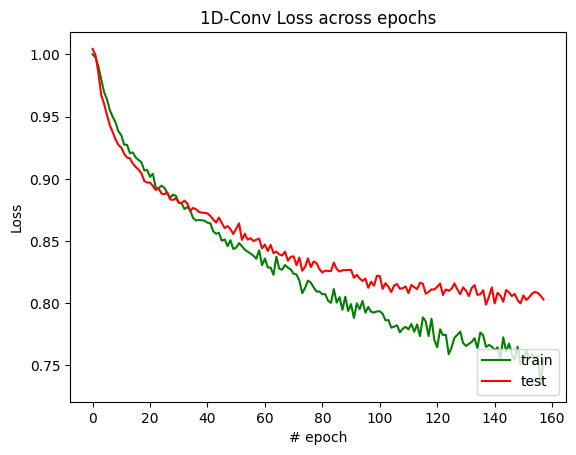

In [ ]:
# show plot accuracy changes during training

plt.plot(history2.history['loss'],'g')
plt.plot(history2.history['val_loss'],'r')
plt.title('1D-Conv Loss across epochs')
plt.ylabel('Loss')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Let's go ahead and use our model to make predictions on the test data. Remember, this is a reconstruction model, so the predictions, ideally, should look similar to the original data for normal disks.

In [ ]:
# Use model to predict on test data set
y_pred2 = autoencoder2.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


The next cell will plot a comparison of the original data to the predicted data for a random record. It only shows compares the features for the first day in the sequence. Run it a few times to see how well your model came out.

This record is from a normal disk.


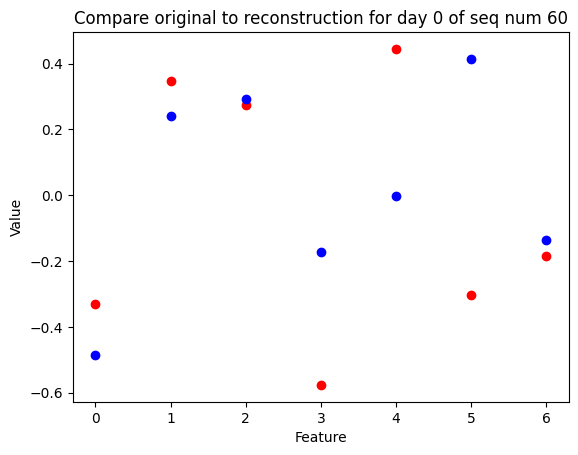

In [ ]:
# create horizontal positions for scatter plot
x_pos = np.arange(x_test.shape[2])

# select random record
rec_num = random.randint(0, y_pred.shape[0])

# plot predicted points
plt.scatter(x_pos, x_test[rec_num,0,:], c="#ff0000")
plt.scatter(x_pos, y_pred2[rec_num,0,:], c="#0000ff")

# label graph
plt.xlabel("Feature")
plt.ylabel("Value")
plt.xticks(range(x_test.shape[2]))
plt.title("Compare original to reconstruction for day 0 of seq num " + str(rec_num))

if y_seq_test[rec_num] == 0:
    print("This record is from a normal disk.")
else:
    print("This record is from an anomalous disk.")

Like before, we need to determine a "threshold" of difference in detecting an anomaly. We'll use the same technique on the new data to determine our threshold.

In [ ]:
# Calcuate MSE for all sequences and predictions
import statistics

# determine median mse to split data into normal vs anomaly
pred_mse2 = []  # calculated mse for test data
pred_res2 = []  # result: 0 normal, 1 anomaly

for i in range(len(x_test)):
    pred_mse2.append(mean_squared_error(y_pred2[i,:,:], x_test[i,:,:]))

# Find number of disks that we know are normal and use that value as splitting point for data
num_normal_disks = list(y_seq_test).count(0)

sort_mse2 = pred_mse2.copy()
sort_mse2.sort()
suggested_threshold2 = sort_mse2[num_normal_disks]
print("Suggested Threshold:", suggested_threshold2)

Suggested Threshold: 1.2515292984190245


In [ ]:
# Routine to specify whether or not a sequence is anomalous

# specify override threshold or leave 0 to use suggested threshold
override_threshold2 = 0

if override_threshold2 == 0:
    threshold2 = suggested_threshold2
else:
    threshold2 = override_threshold2

for mse in pred_mse2:
    if (mse <= threshold2):
        pred_res2.append(0)
    else:
        pred_res2.append(1)

print("Used threshold:", threshold2)
print("Resulting in the following classification of predicted data:")
print("- Normal Disks:   ", pred_res2.count(0))
print("- Anomalous Disks:", pred_res2.count(1))

Used threshold: 1.2515292984190245
Resulting in the following classification of predicted data:
- Normal Disks:    122
- Anomalous Disks: 3


## ROC Curve

The ROC curve plots the False Positive rate along the horizontal axis and the True Positive rate along the vertical axis. False Positive rate and True Positive rate will change based on the various threshold values.

The threshold is high at the y-intercept, resulting in a 0% False Positive rate and a low True Positive rate. As the threshold decreases, the True Positive rate will increase but so will the False Positive rate.

Perfect classification occurs if the distribution of anomalous disks and normal disks are completely separated. This would yield a point in the upper left corner of the ROC space, where the False Positive rate is 0% and the True Positive rate is 100%.

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

Check the ROC curve of the LSTM model.

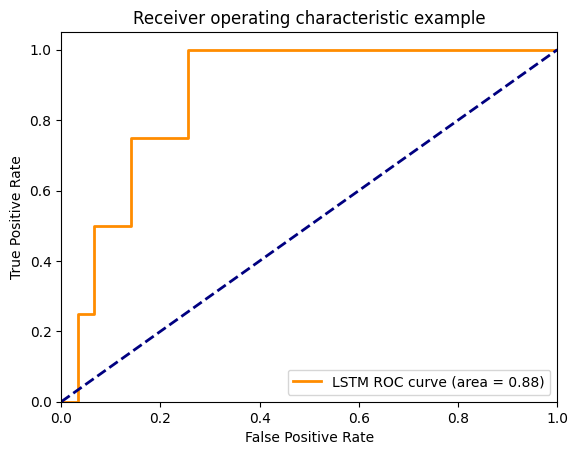

In [ ]:
from sklearn.metrics import roc_curve, auc


def roc_auc_show(pred_y, y_label, figure_label_name='LSTM'):
    fpr, tpr, _ = roc_curve(y_label, pred_y)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label=figure_label_name + ' ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

roc_auc_show(pred_mse, y_seq_test)

Check the ROC curve of the 1D-Conv model.

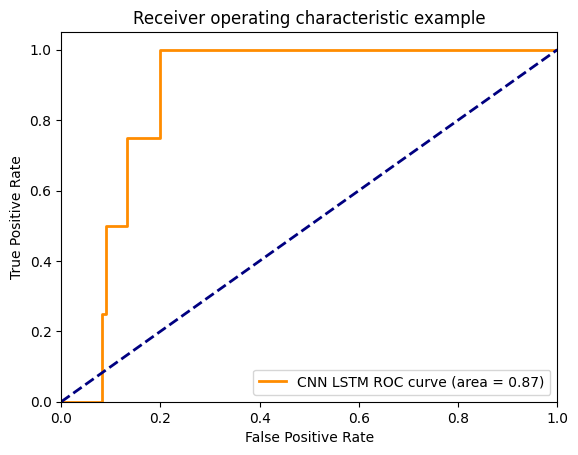

In [ ]:
roc_auc_show(pred_mse2, y_seq_test, figure_label_name='CNN LSTM')

### Performance comparison of LSTM and 1D-Conv models

Now that you've tested both LSTM and the 1D Convultional anomaly detectors, how do you think their accuracy and performance compared?

In [ ]:
y_test_new

[0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1]

In [ ]:
from sklearn.metrics import classification_report

y_test_new = []

for i in np.arange(0, len(y_test), sequence_length):
    y_test_new.append(max(y_test[i:i+sequence_length]))

print('For LSTM AE')
print(classification_report(y_test_new, pred_res))
print('For 1D Conv AE')
print(classification_report(y_test_new, pred_res2))

For LSTM AE
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        76
           1       1.00      0.06      0.12        49

    accuracy                           0.63       125
   macro avg       0.81      0.53      0.44       125
weighted avg       0.77      0.63      0.51       125

For 1D Conv AE
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        76
           1       1.00      0.06      0.12        49

    accuracy                           0.63       125
   macro avg       0.81      0.53      0.44       125
weighted avg       0.77      0.63      0.51       125



## STOP HERE -- END OF SESSION 3
We will complete Exercise 3 as part of next session of DLI.

<a name="e4"></a>
### Exercise 3: Experimenting with Hyperparameters

Now that you've worked your through the entire notebook, feel free to go back and adjust the models to see if you can improve accuracy.  You can add layers, increase filters, and change hyperparameters.  This is where the real art of Deep Learning happens...

However, it is possible to take a systematic approach to hyperparameter optimization by sweeping the space of all parameter values and finding those which maximize some metric you're interested in.  We can then define a function to construct our model based on a given set of parameters, as well as define a scoring function which creates and trains the model and evaluates it's performance. There are many approaches to perform hyperparameter optimization using Deep Learning models. We will explore one concept called Bayesian Optimization which is a fairly common approach for this type of optimization.  

In this example, we'll continue with the LSTM model designed previously and set up the parameter search space to include adjusting the dropout rate and LSTM width along with a factor describing how much of the suggested threshold to use when classifying a defective disk.  In more complicated models, other hyperparameters such as the number of stacked LSTM layers or convolution kernel width could be included in the search space.  Just keep in mind that each new parameter will expand the search space and require more time to maximize.

![Bayesian Optimization](https://raw.githubusercontent.com/fmfn/BayesianOptimization/master/examples/bayesian_optimization.gif)

Import the python package for optimizing the architecture for the LSTM autoencoder

In [ ]:
#pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

Now we can create a class **Hyperparameter** to create inputs for the optimization and provide a mapping between unscaled parameters required by optimizater and scaled parameters used in the method **lstm_autoencoder** defined below:   

In [ ]:
class Hyperparameter:

    def __init__(self,inputs=None):

        _defaults = {"min": 0, "max": 1.0, "count": 11, "scale" : "linear", "type" : "float" }

        for key in sorted(_defaults.keys()):
            try:
                _defaults[key] = inputs[key]
            except:
                pass

        if inputs is not None:
            for key in sorted(_defaults.keys()):
                try:
                    eval("self.set_"+key)(_defaults[key])
                except:
                    print(key + "not defined for Hyperparameter " )
            self.update()

        print(self)

    def set_min(self,val=None):
        self.min = val

    def set_max(self,val=None):
        self.max = val

    def set_count(self,val=None):
        self.count = val

    def set_step(self,val=None):
        self.step = val

    def set_type(self,val=None):
        self.type = val

    def set_scale(self,val=None):
        self.scale = val

    def update(self):
        if self.scale == "log":
             self.step = (np.log(self.max) - np.log(self.min))/(self.count-1)
        else:
             self.step = (self.max - self.min)/(self.count-1)
        if self.type == "int":
            self.step = int(self.step)

    def from_unscaled(self,val=None):
        if self.scale == "log":
            _tval =  np.exp(np.log(self.min) + self.step*val)
        else:
            _tval =  self.min + self.step*val

        if self.type == "int":
            _tval = int(_tval)

        return _tval

    def to_unscaled(self,val=None):
        if self.scale == "log":
            _tval =  (np.log(val) - np.log(self.min))/self.step
        else:
            _tval =  (val - self.min)/self.step

        if self.type == "int":
            _tval = int(_tval)

        return _tval

    def __repr__(self):

        _cur_str = ' Hyperparameter (min: {}, max: {}, scale: {}, step: {}, count: {}, type: {})'.format(self.min,
                                         self.max,
                                         self.scale,
                                         self.step,
                                         self.count,
                                         self.type )
        return  _cur_str


Method to plot the training history of each architecture

In [ ]:
def plot_history(history,result,lw,lr):
    plt.figure()
    plt.plot(history['loss'],'g')
    plt.plot(history['val_loss'],'r')

    plt.ylabel('Loss')
    plt.xlabel('# epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.ylim([0.15,0.55])
    plt.title("LSTM Loss across epochs \n lstm width {:7d} learning rate {:7.4f} objective {:7.4f}" .format(lw,lr,result))

<br>
Next define a function to train the model and return the accuracy:

In [ ]:
# Model #1 - Wide LSTM-based Encoder-Decoder
data_shape = x_train.shape[1:]

dp_lvl = 0.2

def lstm_autoencoder(data_shape, params_list):


    mod_params = {}
    mod_params['lstm_width'] = lstm_width.from_unscaled(int(np.round(params_list[0])))
    mod_params['learning_rate'] = learning_rate.from_unscaled(params_list[1])
    mod_params['num_epochs'] = 20
    mod_params['batch_size'] = 128

    inputs = Input(shape=(data_shape))
    encoded = LSTM(int(mod_params["lstm_width"]), dropout = dp_lvl, recurrent_dropout = dp_lvl, return_sequences =  False, activation='relu')(inputs)
    decoded = RepeatVector(data_shape[0])(encoded)
    decoded = LSTM(int(mod_params["lstm_width"]), return_sequences=True, activation='relu')(decoded)
    decoded = LSTM(data_shape[1], activation='tanh', return_sequences=True)(decoded)

    # Build entire model
    autoencoder = Model(inputs, decoded)

    filename = "case_%.3e_%d_best_model_ae-lstm.keras" %  \
                                 (mod_params["learning_rate"],mod_params["lstm_width"])
    if print_flag == 1:
        print(autoencoder.summary())
    return autoencoder, filename, mod_params

#### Utility methods for plotting and reporting resutls

In [ ]:
def print_history(num_step, mod_params, loss, result, num_train, num_non_train, run_time):

    if num_step == 0:
        print("\n| {:>9s} | {:>10s} | {:>13s} | {:>6s} | {:>9s} | {:>9s} | {:>13s} | {:>15s} | \n|".format("Iteration", "lstm width",
                                                                         "learning rate",
                                                                         "loss","objective", "trainable", "non trainable",
                                                                         "run time (mins)")+'-'*107+"|")

    print( "| {:>9d} | {:>10d} | {:>13.6f} | {:>6.4f} | {:>9.4f} | {:>9d} | {:>13d} | {:>15.4f} |".format( num_step + 1,
        mod_params['lstm_width'],mod_params['learning_rate'],loss, result, num_train, num_non_train, run_time))

In [ ]:
def plot_model_loss(idx_list,header):

    print(" "*20 + header)
    for idx in idx_list:
        cur_iter = iter_history[idx]
        iter_history[idx]["model"].summary()
        plot_history(cur_iter["history"],cur_iter['objective'],
                     cur_iter['params']["lstm_width"],cur_iter['params']["learning_rate"])

In [ ]:
def plot_loss_map(results_list):
    results_list_shifted = [r - 0.9*min_res for r in results_list]
    plt.figure(figsize=(6,4))
    plt.scatter([c['params']['lstm_width'] for c in iter_history],
                [c['params']['learning_rate'] for c in iter_history],
                s=[r*500 for r in results_list_shifted],
                c=[r for r in results_list_shifted ])

    for i,c in enumerate(iter_history):
        plt.text(c['params']['lstm_width'], c['params']['learning_rate'], r'%d'%(i),fontsize = 14)
    plt.xlabel('lstm_width',fontsize=14)
    plt.ylabel('learning_rate',fontsize=14)
    plt.tick_params(labelsize=12)
    plt.yscale('log')

<br>

### Main method for building the autoencoder
This method builds the autoencoder and trains using provided data using
* method **lstm_autoencoder**
* print history of training with the inputs to the architecture of the LSTM model

In [ ]:
import statistics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print_flag = 0
iter_history = []

def count_params(model, param_type = "train"): # Compute number of params in a model (the actual number of floats)
    if param_type == "train":
        return sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    else:
        return sum([np.prod(K.get_value(w).shape) for w in model.non_trainable_weights])

def train_and_fit_AE(param1, param2):

    time_start = time.time()
    autoencoder, filename, params  = lstm_autoencoder(data_shape, [param1, param2])

    # checkpoint
    checkpoint = ModelCheckpoint(data_dir+filename, monitor='val_loss',
                                 verbose=print_flag, save_best_only=True, mode='min')
    es = EarlyStopping(patience=15, verbose=print_flag)

    optimizer = Adam(learning_rate=params['learning_rate'])
    autoencoder.compile(optimizer=optimizer, loss='mae')

    history = autoencoder.fit(x_train, x_train, batch_size=params['batch_size'], epochs=params['num_epochs'],
                              validation_split=0.1, verbose=print_flag, callbacks=[es, checkpoint])
    loss = history.history["val_loss"][-1]
    if np.isnan(loss) : loss = 1e8
    result = np.exp(-20*loss**2)

    print_history(len(iter_history), params, loss, result,
                  count_params(autoencoder,"train"),
                  count_params(autoencoder,"non_train"),
                  (time.time()-time_start)/60.0)
    iter_history.append({'objective':result, 'params': params, 'history':history.history, "model" : autoencoder})

    return result


Let's define the parameter space:

In [ ]:
lstm_width = Hyperparameter({"min": 32, "max": 128, "count": 15, "type" : "int" })
learning_rate = Hyperparameter({"min": 0.0005, "max": 0.1, "count": 15, "scale" : "log"})

pbounds = {"param1"       : (0,lstm_width.count-1),
           "param2"    : (0,learning_rate.count-1)}

 Hyperparameter (min: 32, max: 128, scale: linear, step: 6, count: 15, type: int)
 Hyperparameter (min: 0.0005, max: 0.1, scale: log, step: 0.37845124046771694, count: 15, type: float)


Let's run one test of our "train_and_fit" function to ensure it runs correctly.

In [ ]:
print_flag = 1
train_and_fit_AE(lstm_width.to_unscaled(80),learning_rate.to_unscaled(0.003317))

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 16, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 80)                  │          28,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 16, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 16, 80)              │          51,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 16, 7)               │           2,464 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,144 (320.88 KB)

 Trainable params: 82,144 (320.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.7404
Epoch 1: val_loss improved from inf to 0.71814, saving model to ./data/case_3.317e-03_80_best_model_ae-lstm.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - loss: 0.7357 - val_loss: 0.7181
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7082
Epoch 2: val_loss improved from 0.71814 to 0.71394, saving model to ./data/case_3.317e-03_80_best_model_ae-lstm.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.7099 - val_loss: 0.7139
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.7074
Epoch 3: val_loss improved from 0.71394 to 0.70916, saving model to ./data/case_3.317e-03_80_best_model_ae-lstm.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.7074 - val_loss: 0.7092
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.7048
Epoch 4: val_loss improved from 0.70916 to 0.70172, saving model to ./data/case_3.317e-03_80_best_model_ae-lstm.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.7037 -

8.78660471191928e-05

Now, let's the define Bayesian Optimization environment using the our model function:

In [ ]:
optimizer = BayesianOptimization(
    f=train_and_fit_AE,
    pbounds=pbounds,
    verbose=0, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

### Main call to optimizer
Run the optimizer to explore the parameter space. Each call to the method can take a few minutes. So the total time is almost 15-20 minutes. How can this be improved ?

Suggestions for  experimentation (outside of current DLI):
* **init_points** specifies the initial number of calls to the **lstm_autoencoder** using random parameters. This is used to get initial values to populate our search space. This can be done in parallel.
* **n_iter** specifies the subsequent number of steps to leverage the prior results to search through new architectures using the most optimal possible parameters.  This is where we leverage Bayesian Optimization to optimize our model.

In [ ]:
print_flag = 0
iter_history = []

init_points = 8
num_steps = 8

optimizer.maximize(
    init_points=init_points,
    n_iter=num_steps,
)


| Iteration | lstm width | learning rate |   loss | objective | trainable | non trainable | run time (mins) | 
|-----------------------------------------------------------------------------------------------------------|
|         1 |         68 |      0.022723 | 0.6929 |    0.0001 |     60064 |             0 |          0.2307 |
|         2 |         32 |      0.002481 | 0.6866 |    0.0001 |     14560 |             0 |          0.1894 |
|         3 |         44 |      0.000816 | 0.6991 |    0.0001 |     26272 |             0 |          0.2026 |
|         4 |         50 |      0.003120 | 0.6875 |    0.0001 |     33424 |             0 |          0.1898 |
|         5 |         68 |      0.008686 | 0.6799 |    0.0001 |     60064 |             0 |          0.2072 |
|         6 |         68 |      0.018866 | 0.6903 |    0.0001 |     60064 |             0 |          0.2257 |
|         7 |         50 |      0.052426 | 0.9613 |    0.0000 |     33424 |             0 |          0.1990 |
|       

<br>

### Example output from optimization

<img src="./images/optresult.png" alt="optresult"/>

<!-- ![image.png](attachment:image.png) -->

<br>

### Processing the results
Bayesian optimization has provided several options for improved architectures. Some of the architectures are similar while there are quite a few which are different. It is useful to sort the architectures and take a look at the best performing ones. The next few steps sort and plot the best architectures.
#### Sort the architectures with loss

In [ ]:
results_list = [cur_iter['objective'] for cur_iter in iter_history]

idx_sorted = sorted(range(len(results_list)), key=results_list.__getitem__)
min_res = results_list[idx_sorted[0]]
max_res = results_list[idx_sorted[-1]]

<a name="a3"></a>
#### Plot the loss per epoch for the best three cases

                    Best cases


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 16, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 68)                  │          20,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_8 (RepeatVector)       │ (None, 16, 68)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 16, 68)              │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 16, 7)               │           2,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 180,194 (703.89 KB)

 Trainable params: 60,064 (234.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 120,130 (469.26 KB)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 16, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_11 (RepeatVector)      │ (None, 16, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 16, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 16, 7)               │           1,120 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,682 (170.64 KB)

 Trainable params: 14,560 (56.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,122 (113.76 KB)

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 16, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_45 (LSTM)                       │ (None, 104)                 │          46,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_15 (RepeatVector)      │ (None, 16, 104)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_46 (LSTM)                       │ (None, 16, 104)             │          86,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_47 (LSTM)                       │ (None, 16, 7)               │           3,136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,018 (1.56 MB)

 Trainable params: 136,672 (533.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 273,346 (1.04 MB)

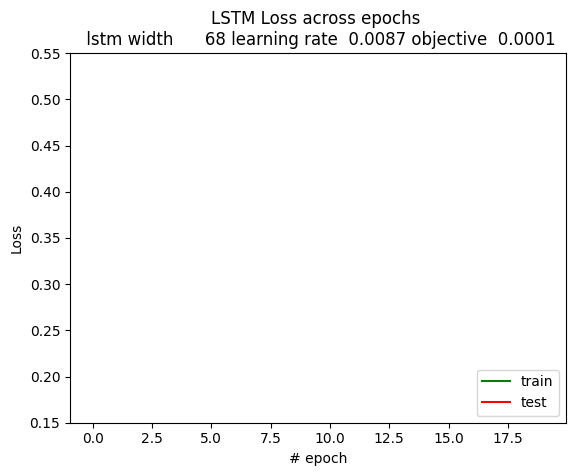

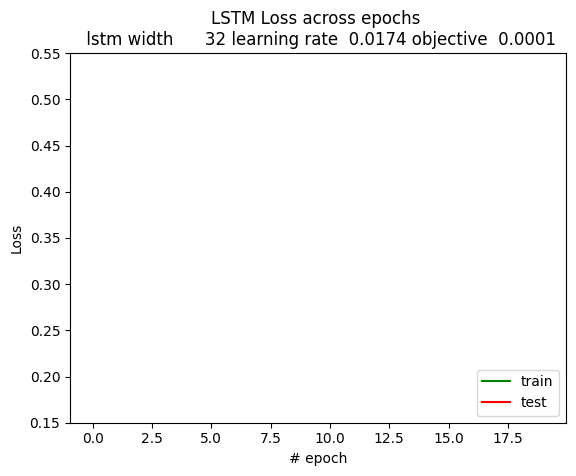

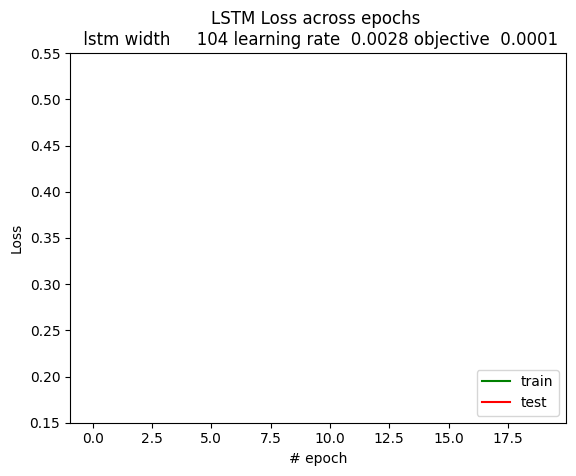

In [ ]:
plot_model_loss([idx_sorted[-1-i] for i in range(3)],"Best cases")

<br>

**An example loss curve for a good architecture**
![Loss example 1](./images/loss_crv_ex1.png)

<a name="a4"></a>
#### Plot the loss per epoch for the worst three cases

                    Worst cases


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 16, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 50)                  │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_10 (RepeatVector)      │ (None, 16, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 16, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 16, 7)               │           1,624 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,274 (391.70 KB)

 Trainable params: 33,424 (130.56 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,850 (261.14 KB)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 16, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_54 (LSTM)                       │ (None, 116)                 │          57,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_18 (RepeatVector)      │ (None, 16, 116)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_55 (LSTM)                       │ (None, 16, 116)             │         108,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_56 (LSTM)                       │ (None, 16, 7)               │           3,472 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 507,362 (1.94 MB)

 Trainable params: 169,120 (660.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 338,242 (1.29 MB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 16, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 44)                  │           9,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_6 (RepeatVector)       │ (None, 16, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 16, 44)              │          15,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 16, 7)               │           1,456 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,818 (307.89 KB)

 Trainable params: 26,272 (102.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,546 (205.26 KB)

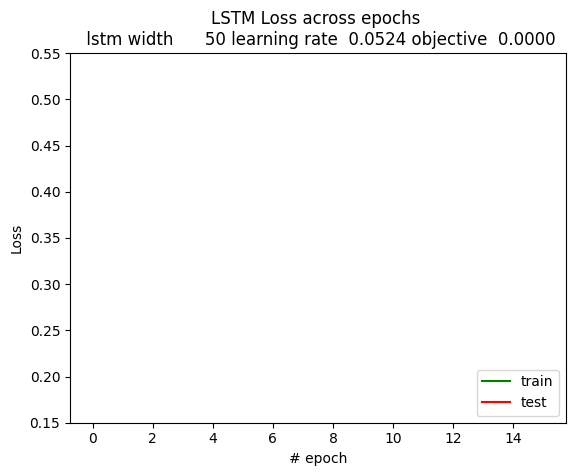

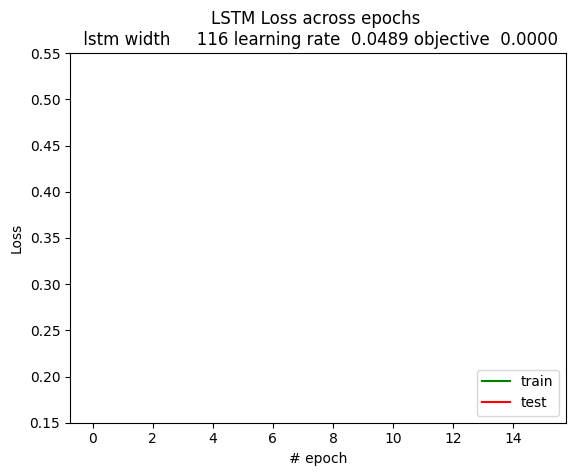

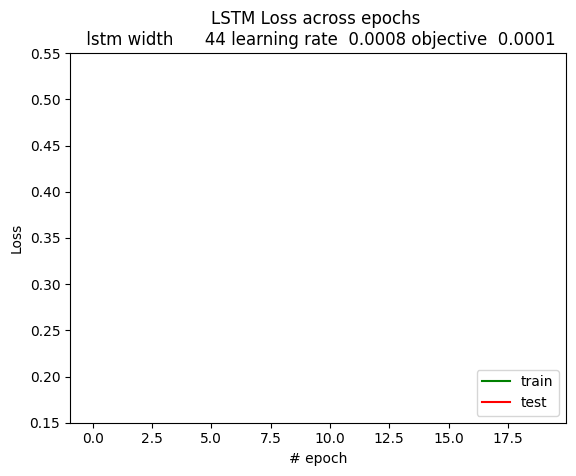

In [ ]:
plot_model_loss([idx_sorted[i] for i in range(3)],"Worst cases")

<br>

**A typical loss curve for a bad architecture**
![Loss example 2](./images/loss_crv_ex2.png)

<a name="a5"></a>
#### Plot different architectures in a 2D space representating the different architectures with the minimum loss as the size

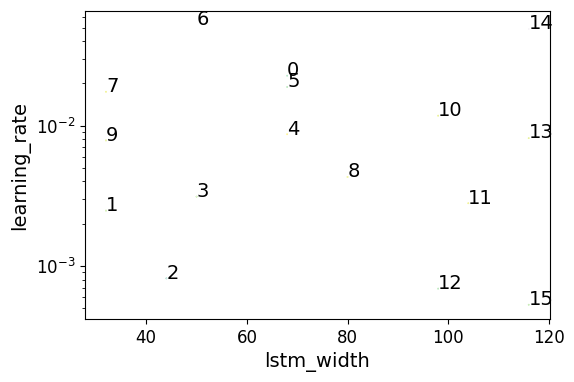

In [ ]:
plot_loss_map(results_list)

<br>

**An example map for the loss with the inputs for the lstm autoencoder**
![Loss example 1](./images/loss_map.png)

<a name="e5"></a>
### Exercise 4: Update code to use specified validation data

The test data can also be specified as a separate dataset rather than being specified as a fraction of the dataset. This is useful especially in situations where it is important to have a certain structure in the test data representative of the training dataset, rather than a randomly sampled section of the main dataset. **train_and_fit_AE** method needs to be specified.

As an exercise, please update the << TO DO >> below with the appropriate validation data using the test data set as the features and label.

<a name="q1"></a>


In [ ]:
import statistics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print_flag = 0
iter_history = []

def train_and_fit_AE(param1, param2):

    time_start = time.time()
    autoencoder, filename, params  = lstm_autoencoder(data_shape, [param1, param2])

    # checkpoint
    checkpoint = ModelCheckpoint(data_dir+filename, monitor='val_loss',
                                 verbose=print_flag, save_best_only=True, mode='min')
    es = EarlyStopping(patience=15, verbose=print_flag)

    optimizer = Adam(lr=params['learning_rate'])
    autoencoder.compile(optimizer=optimizer, loss='mae')

    history = autoencoder.fit(x_train, x_train, batch_size=params['batch_size'], epochs=params['num_epochs'],
                              validation_data=<<TO DO>>, verbose=print_flag, callbacks=[es, checkpoint])

    loss = history.history["val_loss"][-1]
    if np.isnan(loss) : loss = 1e8
    result = np.exp(-20*loss**2)

    print_history(len(iter_history), params, loss, result,
                  count_params(autoencoder,"train"),
                  count_params(autoencoder,"non_train"),
                  (time.time()-time_start)/60.0)
    iter_history.append({'objective':result, 'params': params, 'history':history.history, "model" : autoencoder})

    return result


SyntaxError: invalid syntax (<ipython-input-85-e39cc1ec2e29>, line 21)

Click [here](#a2) to see answer

In [ ]:
optimizer = BayesianOptimization(
    f=train_and_fit_AE,
    pbounds=pbounds,
    verbose=0, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

print_flag = 0
iter_history = []

init_points = 8
num_steps = 8

optimizer.maximize(
    init_points=init_points,
    n_iter=num_steps,
)

<a name="e6"></a>
### Exercise 5: Create HPO result plots
Now the results of this new hyperparameter optimization can be analyzed in a similar way as the previous particular dataset.
* sort the architectures
* loss vs epoch for best three architectures
* loss vs epoch for worst three architectures
* map of training and test loss with key parameters of the architectures - learning rate and lstm width

The code required below is used from the plotting above. <br>
Use the hyperlinks to go to the appropriate session and scroll down to this section to complete the exercise.

#### Sort the architectures with loss   

In [ ]:
results_list = [cur_iter['objective'] for cur_iter in iter_history]

idx_sorted = sorted(range(len(results_list)), key=results_list.__getitem__)
min_res = results_list[idx_sorted[0]]
max_res = results_list[idx_sorted[-1]]

**Plot the loss per epoch for the best three cases**

In [ ]:
plot_model_loss([idx_sorted[-1-i] for i in range(3)],"Best cases")

**Plot the loss per epoch for the worst three cases**

In [ ]:
plot_model_loss([idx_sorted[i] for i in range(3)],"Worst cases")

**Plot different architectures in a 2D space representating the different architectures with the minimum loss as the size**

In [ ]:
plot_loss_map(results_list)


## Results of specifying a different validation dataset
It is important to understand the role of data in prediction quality of models. In the first exercise of hyperparameter optimization, a fraction of the main dataset is used which is randomly sampled. In the second exercise of hyperparameter optimization, the test dataset for XGBoost in Lab1 is used. The distribution of the sensor data is different from the main dataset. A histogram of the both datasets is shown below.
<br>

This leads to the difference in training of the autoencoder models and the loss for each model and, eventually an impact on the direction of hyperparameter optimization.

<img src="./images/histogram_lab1.png" alt="histogram lab 1" width="700"/>

<br>
<br>

## Optional Exercise

Update **train_and_fit_AE** to optimize the autoencoder based on 1D convolutions example discussed in this lab.
* What are the key components to perform the hyperparameter optimization ?
* What can be inputs to the optimization ?
* How should the objective function be structured ?   

**Exercise**: Define the method to create the autoencoder model with input parameters using tf.keras

In [ ]:
# Model #2 -Conv1D-based Encoder-Decoder
data_shape = x_train.shape[1:]

dp_lvl = 0.2

def conv1d_autoencoder(data_shape, params_list):


    mod_params = {}
    #convert from unscaled inputs provided by optimizer using params_list

    inputs = Input(shape=(data_shape))
    #add code for Conv1D
    << TO DO>>

    # Build entire model
    autoencoder = Model(inputs, <<TO DO>> )

    # provide an output filename for storing model weights for lowest loss for the current architecture
    filename = << TO DO>>

    if print_flag == 1:
        print(autoencoder.summary())
    return autoencoder, filename, mod_params

**Exercise**: Define the method to create the autoencoder model with input parameters using tf.keras. No change in needed but the cell below must be run

In [ ]:
print_flag = 0
iter_history = []

def train_and_fit_AE(param1, param2):

    time_start = time.time()
    autoencoder, filename, params  = conv1d_autoencoder(data_shape, [param1, param2])

    # checkpoint
    checkpoint = ModelCheckpoint(data_dir+filename, monitor='val_loss',
                                 verbose=print_flag, save_best_only=True, mode='min')
    es = EarlyStopping(patience=15, verbose=print_flag)

    optimizer = Adam(lr=params['learning_rate'])
    autoencoder.compile(optimizer=optimizer, loss='mae')

    history = autoencoder.fit(x_train, x_train, batch_size=params['batch_size'], epochs=params['num_epochs'],
                              validation_split=0.1, verbose=print_flag, callbacks=[es, checkpoint])
    loss = history.history["val_loss"][-1]
    if np.isnan(loss) : loss = 1e8
    result = np.exp(-20*loss**2)

    print_history(len(iter_history), params, loss, result,
                  count_params(autoencoder,"train"),
                  count_params(autoencoder,"non_train"),
                  (time.time()-time_start)/60.0)
    iter_history.append({'objective':result, 'params': params, 'history':history.history, "model" : autoencoder})

    return result


**Exercise**: Define the method to create the autoencoder model with input parameters using tf.keras

In [ ]:
conv1d_param1 = Hyperparameter({"min": <<TO DO>>, "max": <<TO DO>>, "count": <<TO DO>>, "type" : <<TO DO>> })
conv1d_param2 = Hyperparameter({"min": <<TO DO>>, "max": <<TO DO>>, "count": <<TO DO>>, "scale" : <<TO DO>> })

pbounds = {"param1"    : (0,conv1d_param1.count-1),
           "param2"    : (0,conv1d_param2.count-1)}

**Exercise**: Define the method to create the autoencoder model with input parameters using tf.keras

In [ ]:
print_flag = 1
train_and_fit_AE(conv1d_param1.to_unscaled(<<TO DO>>),conv1d_param2.to_unscaled(<<TO DO>>))

#### Define the optimizer using the new method to call Conv1d based autoencoder

In [ ]:
optimizer = BayesianOptimization(
    f=train_and_fit_AE,
    pbounds=pbounds,
    verbose=0, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

#### Run optimization

In [ ]:
print_flag = 0
iter_history = []

init_points = 8
num_steps = 8

optimizer.maximize(
    init_points=init_points,
    n_iter=num_steps,
)

#### Sort architectures

In [ ]:
results_list = [cur_iter['objective'] for cur_iter in iter_history]

idx_sorted = sorted(range(len(results_list)), key=results_list.__getitem__)
min_res = results_list[idx_sorted[0]]
max_res = results_list[idx_sorted[-1]]

**Plot the loss per epoch for the best three cases**

In [ ]:
plot_model_loss([idx_sorted[-1-i] for i in range(3)],"Best cases")

**Plot the loss per epoch for the worst three cases**

In [ ]:
plot_model_loss([idx_sorted[i] for i in range(3)],"Worst cases")

**Plot different architectures in a 2D space representating the different architectures with the minimum loss as the size**

In [ ]:
plot_loss_map(results_list)

## Summary

In this course, we tackled the predictive maintenance problem using different approaches. Mainly, we used a machine-learning-based approach called XGBoost to classify the defective hard drive samples. Next, we used recurrent neural networks to predict hard drive feature sequences and indicate whether the timeseries ends in a fail state or not. Finally, we used an anomaly detection approach to classify samples into defective/normal bins.
One important factor affecting the outcome of all the models experimented in this course, is the number of data sequences. While we had the liberty of choosing among a dataset of 6M samples, the defective hard drives were significantly less. This challenge affected the outcome of the models discussed so far. To overcome similar issues in industrial applications, the reader is encouraged to investigate data augmentation techniques to increase the training set.

<a name="Updating the autoencoder validation data"></a>
## Answers to selected exercises:
---

<a name="a1"></a>
Exercise 1: Updating the autoencoder validation data

In [ ]:
def get_Labels(df):
    # return the proper column in NumPy format
    y_labels = df['failure'].values
    return y_labels

<a name="a1"></a>
Click [here](#e1) to go back

Exercise 4: Updating the autoencoder validation data

In [ ]:
validation_data=(x_test, x_test)

<a name="a2"></a>
Click [here](#q1) to go back

## Answers to Optional Exercise

Click [here](Lab3-AE-For-Anomaly-Detection-soln.ipynb) to go through the complete solution of this lab